## This is the most clear cut version of the notebook for illustrative purpose

In [1]:
import os
import sys
import compgraph


In [2]:
import tensorflow as tf
import networkx as nx
from graph_nets import utils_np, utils_tf
import numpy as np
import tensorflow as tf
import numpy as np
import networkx as nx
from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets import graphs
from graph_nets.demos_tf2 import models
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, eye
import networkx as nx
import numpy as np
import time
from scipy.sparse import kron


2024-03-16 19:17:10.204137: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-16 19:17:14.109059: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-03-16 19:17:14.109279: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-03-16 19:17:14.109289: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [3]:
import multiprocessing as mp
from joblib import Parallel, delayed
from multiprocessing import Pool

def monte_carlo_update(graph_tuple, gnn, N_sweeps):
    """Perform N_sweeps Monte Carlo updates on a single graph tuple and its corresponding configuration."""
    for _ in range(N_sweeps):
        # Propose a new graph tuple
        proposed_nodes = graph_tuple.nodes.numpy().copy()  # Convert to numpy array for mutability
        i = np.random.randint(len(proposed_nodes))  # Choose a random node
        proposed_nodes[i, 0] *= -1  # Flip the spin at this node

        # Create a new graph tuple with the proposed nodes
        proposed_graph_tuple = graph_tuple.replace(nodes=tf.constant(proposed_nodes))

        # Calculate the acceptance probability
        psi_old = gnn(graph_tuple)[0][0]
        psi_new = gnn(proposed_graph_tuple)[0][0]
        p_accept = min(1, np.abs(psi_new / psi_old)**2)

        # Accept or reject the new graph tuple
        if np.random.rand() < p_accept:
            graph_tuple = proposed_graph_tuple
            
            # Update the corresponding configuration
            value = 0
            for j in range(len(proposed_nodes)):
                b = int(-1 * (proposed_nodes[j, 0] - 1) * 2 ** (j - 1))
                value += b
            one_hot_vector = csr_matrix(([1], ([0], [value])), shape=(1, 2 ** len(proposed_nodes)), dtype=np.int8)
            configuration = one_hot_vector

    return graph_tuple, configuration

###FIND OUT WHY THIS DOES NOT WORK
def parallel_monte_carlo_update(graph_tuples, gnn, N_sweeps):
    """Perform N_sweeps Monte Carlo updates on each graph tuple in a batch."""
    # Apply the monte_carlo_update function to each graph tuple in the batch
    updated_graph_tuples = Parallel(n_jobs=-1)(delayed(monte_carlo_update)(graph_tuple, gnn, N_sweeps) for graph_tuple in graph_tuples)

    return updated_graph_tuples

def sequential_monte_carlo_update(graph_tuples, gnn, N_sweeps):
    updated_graph_tuples_and_configs = [monte_carlo_update(graph_tuple, gnn, N_sweeps) for graph_tuple in graph_tuples]
    updated_graph_tuples, updated_configurations = zip(*updated_graph_tuples_and_configs)
    return list(updated_graph_tuples), list(updated_configurations)
#print(graph_tuples[0].nodes)
#updated_graph_tuples, new_config = sequential_monte_carlo_update(graph_tuples[:1], gnn, 9)
def process_batch(batch):
    graph_tuple, gnn, N_sweeps = batch
    return monte_carlo_update(graph_tuple, gnn, N_sweeps)
"""
def process_batch(batch):
    graph_tuple, gnn, N_sweeps = batch
    return monte_carlo_update(graph_tuple, gnn, N_sweeps)

if __name__ == '__main__':
    # Prepare your batches (replace this with your actual batches)
    batches = [(graph_tuple_1, gnn, N_sweeps), (graph_tuple_2, gnn, N_sweeps), ...]

    # Create a pool of workers
    with Pool(processes=4) as pool:  # Adjust the number of processes as needed
        results = pool.map(process_batch, batches)
#updated_graph_tuples = parallel_monte_carlo_update(graph_tuples, gnn, 9)
print(updated_graph_tuples[0].nodes)
"""


"\ndef process_batch(batch):\n    graph_tuple, gnn, N_sweeps = batch\n    return monte_carlo_update(graph_tuple, gnn, N_sweeps)\n\nif __name__ == '__main__':\n    # Prepare your batches (replace this with your actual batches)\n    batches = [(graph_tuple_1, gnn, N_sweeps), (graph_tuple_2, gnn, N_sweeps), ...]\n\n    # Create a pool of workers\n    with Pool(processes=4) as pool:  # Adjust the number of processes as needed\n        results = pool.map(process_batch, batches)\n#updated_graph_tuples = parallel_monte_carlo_update(graph_tuples, gnn, 9)\nprint(updated_graph_tuples[0].nodes)\n"

In [4]:
##This function computes the stochastic energy given a sample of configurations, here they are specifically computed through
#Markov chains using Metropolis algorithm, and the variational wave_function with the weights, in this case it is represented
#by a GNN. Further we need the Hamiltonian. Ansatz are the trained GNN at step i. 
def StochasticEnergy(random_config_batch, graph_tuples_batch, ansatz, Hamiltonian):
    factor_list=[]
    ansatz_list=[]
    configurations=random_config_batch
    for idx, graph_tuple in enumerate(graph_tuples_batch):
        ansatz_amplitude, ansatz_phase = ansatz(graph_tuple)[0]
        amplitude=tf.cast(ansatz_amplitude, tf.float32)
        ansatz_list.append(amplitude)
        
        phase=tf.cast(ansatz_phase, tf.float32)
        complex_coefficient = tf.complex(amplitude, phase)

        factor_list.append(complex_coefficient)
        print("index", idx, "amplitude", amplitude, configurations[idx])
    energy=0
    #wave_function_csr = compute_wave_function_csr(graph_tuples_batch, ansatz, random_config_batch)
    #print("Confronting the wave fucntion", wave_function_csr, "with the factor list \n" , factor_list,)
    for i in range(len(configurations)):

        v2= configurations[i].transpose()
        v2_factor= factor_list[i]
        en=0
        for index in range(len(configurations)):
            v1= configurations[index]
            v1_factor= factor_list[index]
            psi2=v2_factor*v2
            psi1=v1_factor*v1
            value = psi1.conj().dot(Hamiltonian.dot(psi2))
            #print("this is value", value,"\n","this is v2", v2, "\n", "this is v1", v1, "\n")
            en+=value
        energy += en    
        
    return energy



def Overlap(random_config_batch, graph_tuples_batch, wave1, wave2):
    amplitude1_list= []
    phase1_list=[]
    amplitude2_list= []
    phase2_list=[]
    configurations=random_config_batch
    for graph in range(len(graph_tuples_batch)):
        ansatz1_amplitudes, ansatz1_phases = wave1(graph_tuples_batch[graph])[0]
        amplitude1_list.append(ansatz1_amplitudes)
        phase1_list.append(ansatz1_phases)
        ansatz2_amplitudes, ansatz2_phases = wave2(graph_tuples_batch[graph])[0]
        amplitude2_list.append(ansatz2_amplitudes)
        phase2_list.append(ansatz2_phases)   
    pass     
def compute_wave_function_csr(graph_tuples_batch, ansatz, configurations):
    #TO BE FIXED the wave function currently sums up same configurations coefficients if they are presented multiple times. What should I do here? 
    
    data = []  # List to store the non-zero entries
    row_indices = []  # List to store the row indices
    col_indices = [0] * len(configurations)  # Column indices are all 0 for a vector
    size= 2**len(graph_tuples_batch[0].nodes)

    # Compute the wave function components for each graph tuple
    for idx, graph_tuple in enumerate(graph_tuples_batch):
        amplitude, phase = ansatz(graph_tuple)[0]
        amplitude = tf.cast(amplitude, tf.float32)
        phase = tf.cast(phase, tf.float32)
        
        # Now create the complex coefficient
        complex_coefficient = tf.complex(amplitude, phase)
        # Compute the complex coefficient using TensorFlow operations
        #print(complex_coefficient,configurations[idx])
        
        # Extract the row index from the configuration
        row_index = configurations[idx].indices[0]
        
        # Append the data and indices to the lists
        data.append(complex_coefficient.numpy())
        row_indices.append(row_index)
    
    # Construct the csr_matrix using the accumulated data and indices 
    #Shape it is tbd by other means
    wave_function_csr = csr_matrix((data, (row_indices, col_indices)), shape=(size, 1))
    
    return wave_function_csr
def compute_wave_function_sparse_tensor(graph_tuples_batch, ansatz, configurations):
    values = []  # List to store the non-zero entries
    indices = []  # List to store the indices of non-zero entries
    
    # Compute the wave function components for each graph tuple
    for idx, graph_tuple in enumerate(graph_tuples_batch):
        amplitude, phase = ansatz(graph_tuple)[0]
        
        # Convert amplitude to complex tensor with zero imaginary part
        amplitude_complex = tf.complex(real=amplitude, imag=tf.zeros_like(amplitude))
        
        # Compute the complex coefficient using TensorFlow operations
        complex_coefficient = amplitude_complex * tf.math.exp(tf.complex(real=0.0, imag=phase))
        
        # Extract the row index from the configuration
        row_index = configurations[idx].indices[0]
        
        # Append the data and indices to the lists
        values.append(complex_coefficient)
        indices.append([row_index, 0])
    
    # Convert lists to tensors
    values_tensor = tf.stack(values, axis=0)
    indices_tensor = tf.constant(indices, dtype=tf.int64)
    
    # Create a sparse tensor
    sparse_tensor = tf.sparse.SparseTensor(indices=indices_tensor, values=values_tensor, dense_shape=[512, 1])
    
    return sparse_tensor


In [5]:



def are_configs_identical(config1, config2):
    # Use numpy array equality for vectorized comparison
    return np.array_equal(config1, config2)

def configs_differ_by_two_sites(config1, config2):
    # Use numpy to count the differences in a vectorized manner
    return np.sum(config1 != config2) == 2

def apply_raising_operator(config, site):
    new_config = config.copy()
    if config[site] == -1:
        new_config[site] = 1  # Spin flip from down to up
        return new_config
    else:
        return None  # State is annihilated

def apply_lowering_operator(config, site):
    new_config = config.copy()
    if config[site] == 1:
        new_config[site] = -1  # Spin flip from up to down
        return new_config
    else:
        return None  # State is annihilated

def apply_edge_contribution(config, i, j):
    # Apply the spin raising operator on site i and lowering on site j
    new_config_raised = apply_raising_operator(config, i)
    if new_config_raised is not None:
        new_config_lowered = apply_lowering_operator(new_config_raised, j)
    else:
        new_config_lowered = None

    # Apply the spin lowering operator on site i and raising on site j
    new_config_lowered_initial = apply_lowering_operator(config, i)
    if new_config_lowered_initial is not None:
        new_config_raised = apply_raising_operator(new_config_lowered_initial, j)
    else:
        new_config_raised = None

    # Combine the new configurations if they are not None
    new_configs = []
    if new_config_raised is not None:
        new_configs.append(new_config_raised)
    if new_config_lowered is not None:
        new_configs.append(new_config_lowered)

    return new_configs

                       
def construct_sparse_hamiltonian(Graph, spin_operators, J2):
    Hamiltonian = csr_matrix((2**Graph.number_of_nodes(), 2**Graph.number_of_nodes()))
    # Define the coupling constants
    J1 = 1. 
    node_to_index=nd_to_index(Graph)

    # Iterate over the edges of the graph
    for i, j in Graph.edges:
        print(i,j)
        # Map nodes to indices
        i_index = node_to_index[i]
        j_index = node_to_index[j]

        # Add the interaction term to the Hamiltonian
        term_to_be_add = (0.5*spin_operators[0][i_index]*(spin_operators[1][j_index]) + 
                          0.5*spin_operators[1][i_index]*(spin_operators[0][j_index]) + 
                          spin_operators[2][i_index]*(spin_operators[2][j_index]))
        Hamiltonian += J1 * csr_matrix(term_to_be_add)

    # Add next nearest neighbour interactions
    for i in Graph.nodes:
        i_index = node_to_index[i]
        for j in Graph.neighbors(i):
            j_index = node_to_index[j]
            for k in Graph.neighbors(j):
                if k != i:
                    k_index = node_to_index[k]
                    term= csr_matrix(0.5*spin_operators[0][i_index]*spin_operators[1][k_index] 
                                     + 0.5*spin_operators[1][i_index]*spin_operators[0][k_index] 
                                     +spin_operators[2][i_index]*spin_operators[2][k_index])

                    Hamiltonian += J2 * term
    return Hamiltonian                



## Initialization of the Graph encoding for different configurations and the problem parameters, constant seed for repetibility


The following is a sublattice encoding of a square 
with a Neel State symmetry, i.e. alternated sublattices for adjacent sites

In [6]:
# Set a random seed
start=time.time()
SEED = 1
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Define the lattice size
lattice_size = (2,2)
#Batch size, the number of graphs that will be computed simultaneously by the GNN
batch_size= 32

# Create a square lattice
G = nx.grid_2d_graph(*lattice_size, periodic=True)
# Number of sites
num_sites = lattice_size[0] * lattice_size[1]

# Relabel the nodes to use integers
mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, mapping)
# Initialize the sublattice encoding
sublattice_encoding = np.zeros((num_sites, 2))  # Two sublattices
sublattice_encoding[::2, 0] = 1  # Sublattice 1
sublattice_encoding[1::2, 1] = -1  # Sublattice 2
# Create a dictionary where the keys are the node indices and the values are dictionaries
# containing the 'features' field and the corresponding sublattice encoding
node_dict = {i: {"features": sublattice_encoding[i]} for i in range(num_sites)}
# Use the dictionary to set the node attributes in the graph
#nx.set_node_attributes(G, node_dict)
# Add 'features' to nodes
for node in G.nodes():
    G.nodes[node]['features'] = sublattice_encoding[node]
# Add 'features' to edges
# Add 'features' to edges
for edge in G.edges():
    u, v = edge
    G.edges[u, v]['features'] = [1.0]  # Replace with your actual edge features
    G.edges[v, u]['features'] = [1.0]  # Add undirected edge # Replace with your actual edge features
# Now convert the networkx graph to a GraphsTuple
graph_tuple = utils_np.networkxs_to_graphs_tuple([G])

# Number of configurations to generate
n_configs = 6
n_graph=n_configs*batch_size
# Generate the basis configurations
basis_configs = np.random.randint(2, size=(n_graph, num_sites)) * 2 - 1  # Random spins (-1 or 1)

# Concatenate the basis configurations and the sublattice encoding to form the node features
node_features = np.concatenate([basis_configs[:, :, np.newaxis], np.repeat(sublattice_encoding[np.newaxis, :, :], n_graph, axis=0)], axis=2)

# Get the edge indices
edge_index = np.array(G.edges()).T
edge_index_duplicated = np.concatenate([edge_index, edge_index[::-1]], axis=1)
bias_value=0.05
# Create a list of graph dicts
graph_tuples = []
for i in range(n_graph):
    graph_dict = {
        'globals': np.array([0.5]),
        'nodes': node_features[i],
        'edges': np.full((edge_index_duplicated.shape[1], 1), bias_value),
        'senders': edge_index_duplicated[0],
        'receivers': edge_index_duplicated[1]
    }
    
    # Convert to a GraphsTuple and append to the list
    graph_tuples.append(utils_tf.data_dicts_to_graphs_tuple([graph_dict]))


print("end time:", time.time()-start)

2024-03-16 19:17:18.711882: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-16 19:17:18.772991: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2024-03-16 19:17:18.778910: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2024-03-16 19:17:18.779083: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gp

end time: 1.5725646018981934


In [7]:
import numpy as np

def generate_configurations(N):
    num_configs = 2 ** N
    configurations = np.zeros((num_configs, N), dtype=int)
    
    for k in range(num_configs):
        binary_str = format(k, '0' + str(N) + 'b')
        configuration = np.array([int(bit) for bit in binary_str])
        
        # Map 0 to -1 to represent down spins
        configuration[configuration == 0] = -1
        
        configurations[k, :] = configuration
    
    return configurations

N = 4  # Number of spins
configurations_ordered = generate_configurations(N)
print(len(configurations_ordered))
node_features_2 = np.concatenate([configurations_ordered[:, :, np.newaxis], np.repeat(sublattice_encoding[np.newaxis, :, :], len(configurations_ordered), axis=0)], axis=2)

graph_tuples2 = []
for i in range(len(configurations_ordered)):
    graph_dict = {
        'globals': np.array([0.005]),
        'nodes': node_features_2[i],
        'edges': np.zeros((edge_index_duplicated.shape[1], 1)),
        'senders': edge_index_duplicated[0],
        'receivers': edge_index_duplicated[1]
    }
    # Convert to a GraphsTuple and append to the list
    graph_tuples2.append(utils_tf.data_dicts_to_graphs_tuple([graph_dict]))
configurations_new=[]
b=0
value_list=[]
for configuration in configurations_ordered:
        value=0
        for j in range(len(configuration)):
            b= int(-1*(configuration[j]-1)*2**(j-1))
            value+=b
        value_list.append(value)
        #print(value)
        one_hot_vector = csr_matrix(([1], ([0], [value])), shape=(1, 2 ** len(configuration)), dtype=np.int8)
        configurations_new.append(one_hot_vector) 


16


##### The next subroutine transforms all the spin configurations in one hot basis vector representation, this is needed for sparse Hamiltonian representation, not for the new one

In [8]:
from compgraph.sparse_ham import sites_to_sparse
start_time=time.time()
b=0
configurations, value_list= sites_to_sparse(basis_configs)


print(time.time()-start_time)  


print(configurations[0], basis_configs[0])



0.030942916870117188
  (0, 12)	1 [ 1  1 -1 -1]


### Test of the new Hamiltonian representation wrt to sparse matrix


In [9]:
print(basis_configs[0]+basis_configs[3])
print(basis_configs[0])
print(basis_configs[3])
for config in basis_configs[:4]:
    print(config, "!")
print(G.nodes)
print(value_list)

[ 0  2  0 -2]
[ 1  1 -1 -1]
[-1  1  1 -1]
[ 1  1 -1 -1] !
[1 1 1 1] !
[ 1 -1 -1  1] !
[-1  1  1 -1] !
[0, 1, 2, 3]
[12, 0, 6, 9, 13, 13, 14, 14, 0, 14, 0, 4, 6, 3, 10, 9, 0, 3, 15, 8, 6, 2, 13, 8, 4, 8, 15, 0, 8, 15, 1, 8, 9, 13, 1, 4, 13, 1, 13, 11, 2, 14, 7, 11, 9, 11, 7, 15, 12, 8, 15, 8, 12, 9, 8, 0, 13, 10, 4, 2, 10, 2, 0, 3, 7, 14, 3, 0, 6, 7, 5, 15, 12, 5, 6, 13, 5, 1, 5, 8, 13, 3, 9, 1, 0, 15, 7, 15, 1, 14, 10, 14, 7, 7, 9, 9, 10, 12, 14, 3, 3, 4, 13, 10, 14, 13, 0, 14, 2, 9, 9, 0, 13, 7, 15, 6, 9, 10, 14, 5, 0, 5, 15, 12, 11, 1, 2, 13, 14, 0, 15, 2, 3, 9, 7, 15, 10, 1, 11, 15, 0, 6, 14, 13, 5, 15, 6, 2, 8, 15, 7, 7, 5, 3, 0, 7, 11, 12, 9, 12, 11, 13, 15, 12, 15, 4, 11, 8, 3, 8, 10, 15, 15, 5, 3, 3, 2, 1, 10, 0, 1, 11, 12, 14, 7, 12, 10, 1, 13, 1, 10, 14]


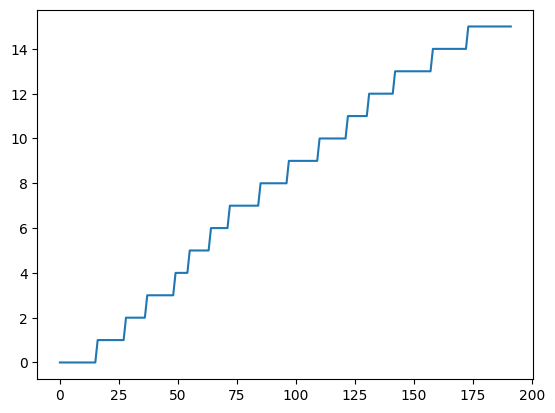

In [10]:
plt.plot(np.sort(value_list))

In [11]:
import networkx as nx
from compgraph.sparse_ham import create_spin_operators, construct_sparse_hamiltonian
from compgraph.cg_repr import Square_2DHam_exp
import qutip as qt
from qutip import tensor, jmat, qeye, Qobj
from compgraph.useful import nd_to_index

J2=2.0
#compute_wave_function_csr
# Example graph definition using networkx
node_to_index = nd_to_index(G)
print("Jelly beans",node_to_index)
# Define the psi and phi vectors with example amplitudes
psi = np.array([2. +1j, 3.2 ])
phi = np.array([1.5 +0.3j])
print("Configs of psi", basis_configs[2], basis_configs[4])
# Define the configurations for psi and phi, they must be given as list of arrays or directly as multidimensional arrays
configs_psi = np.array([basis_configs[2], basis_configs[4]])
configs_phi = np.array([basis_configs[2]])
print("till here fine ")
print("\n", configurations[4],basis_configs[4])
# Calculate the expectation value
size=2**len(G.nodes)
expectation_value = Square_2DHam_exp(psi, G, phi, J2, configs_psi, configs_phi)
print("Expectation Value:", expectation_value)
psi_sparse=csr_matrix((psi, ([configurations[2].indices[0], configurations[4].indices[0]], [0,0])),shape=(size, 1))
phi_sparse=csr_matrix((phi, ([configurations[2].indices[0]], [0])),shape=(size, 1))
# Assuming `construct_sparse_hamiltonian` is already defined and returns the Hamiltonian matrix
spin_operators=create_spin_operators(G)
Hamiltonian = construct_sparse_hamiltonian(G, spin_operators, J2)
# Calculate the expectation value using the Hamiltonian matrix
sparse_expectation_value = psi_sparse.conj().transpose().dot(Hamiltonian.dot((phi_sparse)))
# Output the expectation value for comparison
print("Expectation Value from sparse Hamiltonian:", sparse_expectation_value)
print("Expectation Value from CG notation:", expectation_value)



Jelly beans {0: 0, 1: 1, 2: 2, 3: 3}
Configs of psi [ 1 -1 -1  1] [-1  1 -1 -1]
till here fine 

   (0, 13)	1 [-1  1 -1 -1]
end of square 2d function
Expectation Value: (9.9-2.7j)
0 2
0 1
1 3
2 3
Expectation Value from sparse Hamiltonian:   (0, 0)	(9.9-2.7j)
Expectation Value from CG notation: (9.9-2.7j)


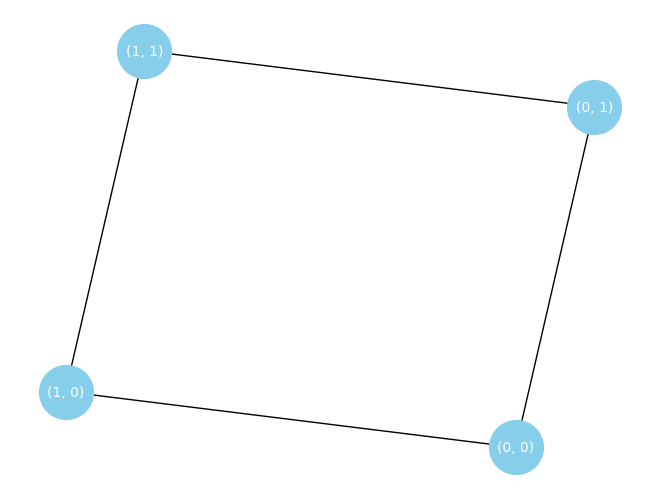

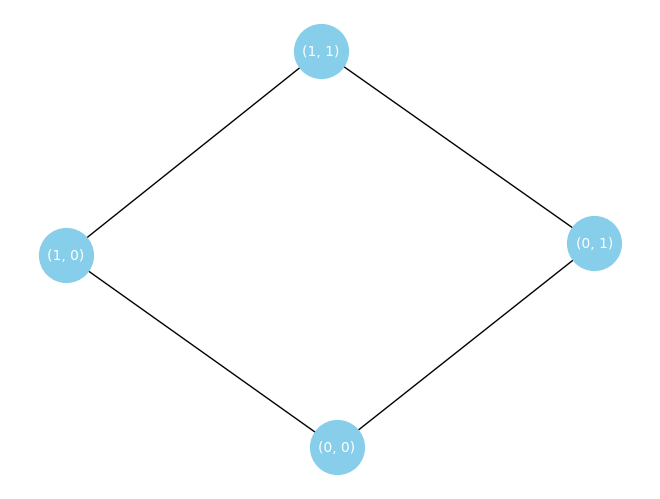

In [12]:
G_vis = nx.grid_graph(dim=lattice_size)
G= nx.grid_graph(dim=lattice_size, periodic=True)

# Draw the graph
pos = nx.spring_layout(G_vis, seed=42)  # positions for all nodes - seed for reproducibility
nx.draw(G_vis, pos, with_labels=True, node_color="skyblue", node_size=1500, font_size=10, font_color="white")

plt.show()

nx.draw(G, with_labels=True, node_color="skyblue", node_size=1500, font_size=10, font_color="white")

## Hamiltonian creation

In [13]:
# Create a graph representing the lattice
G = nx.grid_graph(dim=lattice_size, periodic=True)

## In the following we want to compute the Hamiltonian and find the GS if it's a small one.


In [14]:
import tensorflow as tf
import sonnet as snt
from graph_nets import modules
from graph_nets import blocks
from compgraph.gnn_src_code import GNN_double_output
gnn=GNN_double_output()
start_time=time.time()
for i in range(35):
    a=gnn(graph_tuples[i])[0]
    #print(a)
print("final_time", time.time()-start_time)   



final_time 0.6212878227233887


In [15]:
import tensorflow as tf
import sonnet as snt

def list_layers(module, prefix=''):
    """
    Recursively list the layers and sub-layers of a TensorFlow/Sonnet module.
    
    Args:
    - module: The module from which to list layers.
    - prefix: A prefix for nested layer names to indicate their hierarchy.
    """
    # Check if the module is an instance of the layers we're interested in.
    # Depending on your TensorFlow/Sonnet version, you might need to adjust these checks.
    if isinstance(module, (tf.Module, tf.keras.layers.Layer, snt.Module)):
        print(f"{prefix}{module.name}: {type(module).__name__}")
        
        # Iterate through all attributes of the module.
        for name, attr in module.__dict__.items():
            # Recursively list layers.
            list_layers(attr, prefix=prefix + '  ')

# Instantiate your model
module = GNN_double_output()

# List layers
list_layers(module)

gnn_double_output: GNN_double_output
  graph_network: Encoder
    edge_block: EdgeBlock
      mlp_model_enc: MLPModel_enc
        layer1: Linear
        layer2: Linear
        layer3: Linear
        layer4: Linear
    node_block: NodeBlock
      mlp_model_enc: MLPModel_enc
        layer1: Linear
        layer2: Linear
        layer3: Linear
        layer4: Linear
      received_edges_to_nodes_aggregator: ReceivedEdgesToNodesAggregator
    global_block: GlobalBlock
      mlp_model_glob: MLPModel_glob
        layer1: Linear
        layer2: Linear
      edges_to_globals_aggregator: EdgesToGlobalsAggregator
      nodes_to_globals_aggregator: NodesToGlobalsAggregator
  processor_1: Processor
  graph_network: Decoder
    edge_block: EdgeBlock
      mlp_model_dec: MLPModel_dec
        layer1: Linear
        layer2: Linear
        layer3: Linear
        layer4: Linear
    node_block: NodeBlock
      mlp_model_dec: MLPModel_dec
        layer1: Linear
        layer2: Linear
        layer3: Linea

In [16]:
num_config= 4
training_samples=1 #Just for debugging
for i in range(training_samples):
    start=(i*num_config)%19200
    end=(start +num_config)%19200
    graph_tuples_batch_indices= configurations[start:end]
    print(configurations[0])
    graph_tuples_batch= graph_tuples[start:end]
    print("Graph indices", graph_tuples_batch_indices[0], "graph")
    print("Corresponding graph tuple", graph_tuples_batch[0])

    #print(graph_tuples_batch)
    res=gnn(graph_tuples_batch[0])
    energy=StochasticEnergy(graph_tuples_batch_indices, graph_tuples_batch, gnn , Hamiltonian)
    print("Energy of the system", energy)
    


  (0, 12)	1
Graph indices   (0, 12)	1 graph
Corresponding graph tuple GraphsTuple(nodes=<tf.Tensor: shape=(4, 3), dtype=float64, numpy=
array([[ 1.,  1.,  0.],
       [ 1.,  0., -1.],
       [-1.,  1.,  0.],
       [-1.,  0., -1.]])>, edges=<tf.Tensor: shape=(8, 1), dtype=float64, numpy=
array([[0.05],
       [0.05],
       [0.05],
       [0.05],
       [0.05],
       [0.05],
       [0.05],
       [0.05]])>, receivers=<tf.Tensor: shape=(8,), dtype=int32, numpy=array([2, 1, 3, 3, 0, 0, 1, 2], dtype=int32)>, senders=<tf.Tensor: shape=(8,), dtype=int32, numpy=array([0, 0, 1, 2, 2, 1, 3, 3], dtype=int32)>, globals=<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.5]])>, n_node=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([4], dtype=int32)>, n_edge=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([8], dtype=int32)>)
index 0 amplitude tf.Tensor(-0.041391842, shape=(), dtype=float32)   (0, 12)	1
index 1 amplitude tf.Tensor(0.1613889, shape=(), dtype=float32)   (0, 0)	1
index 2 ampl

In [17]:
start= time.time()
start_idx=0
end_idx=1
graph_tuples_batch = graph_tuples[start_idx:end_idx]
configurations_new = configurations[start_idx:end_idx]
print("Configurations used in compute wave_fucntion", configurations_new[0], " \n")
wave_function = compute_wave_function_csr(graph_tuples_batch, gnn, configurations_new)
print("here is my little wave", wave_function)
beta=0.005
#print("Hamiltonian", Hamiltonian, "Good Check it is alive")

ite= wave_function-beta* Hamiltonian.dot(wave_function)
print("Hamiltonian is good, what about the wave", wave_function)
new_norm= ite.conj().transpose().dot(ite)

print("not yet to be checked", new_norm)
t1= time.time()-start
print("Time elapsed", t1)
###This is to show that computing the wave_function and then the norm using the WF is much quicker then computing the energy several times
start=time.time()
elem1=StochasticEnergy(configurations_new, graph_tuples_batch, gnn , -2*beta*Hamiltonian)

elem0=wave_function.conj().transpose().dot(wave_function)
elem2= StochasticEnergy(configurations_new, graph_tuples_batch, gnn , (beta**2)*Hamiltonian*Hamiltonian) 
print(elem2+elem1 + elem0)

t2=time.time()-start
print(t2)
print("Percentage difference", np.abs(t1-t2)/(t2))

Configurations used in compute wave_fucntion   (0, 12)	1  

here is my little wave   (12, 0)	(-0.041391842+0.21869823j)
Hamiltonian is good, what about the wave   (12, 0)	(-0.041391842+0.21869823j)
not yet to be checked   (0, 0)	(0.05158395986158364+0j)
Time elapsed 0.021310806274414062
index 0 amplitude tf.Tensor(-0.041391842, shape=(), dtype=float32)   (0, 12)	1
index 0 amplitude tf.Tensor(-0.041391842, shape=(), dtype=float32)   (0, 12)	1
  (0, 0)	(0.05158395781472935-1.6940658945086007e-21j)
0.03712964057922363
Percentage difference 0.4260432920447176


#### Now let's dive into the markov chain update


In [18]:
start=time.time()
checker= 3
#print(graph_tuples[checker].nodes)

# Create a new graph tuple with the proposed nodes
for i, graph_tuple in enumerate(graph_tuples[:20000]):
    #print(i)
    proposed_nodes = graph_tuple.nodes.numpy().copy()  # Convert to numpy array for mutability
    j = np.random.randint(len(proposed_nodes))  # Choose a random node
    proposed_nodes[j, 0] *= -1  # Flip the spin at this node
    proposed_graph_tuple = graph_tuple.replace(nodes=tf.constant(proposed_nodes))
    graph_tuple= proposed_graph_tuple
    
# print(graph_tuples[checker].nodes)
print(time.time()-start)

0.01597285270690918


In [19]:
gnn=GNN_double_output()
start_time=time.time()
for i in range(1):
    a=gnn(graph_tuples[i])[0]
# Define the optimizer with the given hyperparameters

initial_learning_rate = 7e-3
decay_steps = 8 * 1e5
decay_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.99, clipnorm=1)


In [20]:
import time
import numpy as np
import tensorflow as tf

batch_size = 32  # Set your batch size
start = 0  # Initialize the start index for batching
N_sweeps = 5  # Number of Monte Carlo sweeps

for step in range(30):  # IT-SWO steps
    # Compute phi once at the beginning of each outer step, this is the ITO of psi
    graph_tuples_batch=graph_tuples[start:start + batch_size]
    graph_tuples_batch_indices= configurations[start:start + batch_size]
    psi_csr = compute_wave_function_csr(graph_tuples_batch, gnn, graph_tuples_batch_indices)
    beta = 0.05
    phi_csr = psi_csr - beta * Hamiltonian.dot(psi_csr)
    phi_sparse_coo = phi_csr.tocoo()
    indices = np.column_stack((phi_sparse_coo.row, phi_sparse_coo.col))
    phi_sparse_tf = tf.cast(tf.sparse.SparseTensor(indices, phi_sparse_coo.data, phi_sparse_coo.shape), dtype=tf.complex64)
    
    for _ in range(3):  # Inner loop iterations: here we let psi approximate its ITO phi
        with tf.GradientTape() as tape:
            tape.watch(gnn.trainable_variables)
            
            loss = loss_sparse_vectors(psi_csr, phi_csr)
            print(loss)
        
        
        gradients = tape.gradient(loss, gnn.trainable_variables)
        optimizer.apply_gradients(zip(gradients, gnn.trainable_variables))
        time_s = time.time()
        # Update graph_tuples and configurations using Monte Carlo updates
        for i in range(start, start + batch_size):
            updated_graph_tuple, updated_configuration = monte_carlo_update(graph_tuples[i], gnn, N_sweeps)
            graph_tuples[i] = updated_graph_tuple
            configurations[i] = updated_configuration
        print(time.time() - time_s, "Monte Carlo update with N_sweeps", N_sweeps)
    
    print(gradients[0][0], "step", step)
    
    
    # Update the start index for the next batch
    start += batch_size


NameError: name 'loss_sparse_vectors' is not defined

# From now on is all trial to compute proximity of wave function to real eigenvector

2.11.0


In [45]:
import tensorflow as tf
from tensorflow.python.ops.linalg.sparse import sparse_csr_matrix_ops




In [55]:
import time
import numpy as np
import tensorflow as tf
from compgraph.sparse_ham import compute_wave_function_csr
from compgraph.tensor_wave_functions import compute_wave_function_sparse_tensor

batch_size = 4  # Set your batch size
start = 0  # Initialize the start index for batching
N_sweeps = 5  # Number of Monte Carlo sweeps
def compute_sparse_tensor_norm(sparse_tensor):
    """

    Args:
    - sparse_tensor: A tf.SparseTensor.

    Returns:
    - The L2 or Euclidean norm of a sparse tensor.
    """
    # Compute the square of the values (i.e., v_i^2 for each non-zero v_i)
    norm = tf.norm(sparse_tensor.values)


    return norm

def tf_multiply(a: tf.SparseTensor, b: tf.SparseTensor):
    a_sm = sparse_csr_matrix_ops.sparse_tensor_to_csr_sparse_matrix(
        a.indices, a.values, a.dense_shape)
    #print(a.dense_shape,'shape of the dense shape of a', a_sm)
    b_sm = sparse_csr_matrix_ops.sparse_tensor_to_csr_sparse_matrix(
        b.indices, b.values, b.dense_shape
    )

    c_sm = sparse_csr_matrix_ops.sparse_matrix_sparse_mat_mul(
        a=a_sm, b=b_sm, transpose_b=True, type=tf.complex64
    )

    c = sparse_csr_matrix_ops.csr_sparse_matrix_to_sparse_tensor(
        c_sm, tf.complex64
    )

    return tf.SparseTensor(
        c.indices, c.values, dense_shape=c.dense_shape
    )
def compute_loss_tensor_updated(psi_sparse, phi_sparse):
    # Compute the conjugate of the sparse tensor values
    psi_sparse_conj = tf.SparseTensor(
        indices=psi_sparse.indices,
        values=tf.math.conj(psi_sparse.values),
        dense_shape=psi_sparse.dense_shape
    )
    
    phi_sparse_conj = tf.SparseTensor(
        indices=phi_sparse.indices,
        values=tf.math.conj(phi_sparse.values),
        dense_shape=phi_sparse.dense_shape
    )
    
    # Reorder the indices of the conjugate sparse tensor
    psi_sparse_conj = tf.sparse.reorder(psi_sparse_conj)
    phi_sparse_conj = tf.sparse.reorder(phi_sparse_conj)

    
    # Compute the norms using sparse-dense matrix multiplication
    psi_norm=compute_sparse_tensor_norm(psi_sparse)
    phi_norm =compute_sparse_tensor_norm(phi_sparse)
    print("norms:", psi_norm, phi_norm)
    denominator = psi_norm * phi_norm
    print(denominator,'DENOMINATOR')
    denominator = tf.cast(denominator, tf.float32)

    # Compute the numerator using dense-sparse matrix multiplication
    numerator = tf_multiply(psi_sparse, phi_sparse_conj)
    #print(psi_sparse, phi_sparse)
    print("numerator", numerator, "Norm" ,"\n", denominator)
    loss = 1.-numerator/denominator
    
    return loss

for step in range(30):  # IT-SWO steps
    # Compute phi once at the beginning of each outer step, this is the ITO of psi
    graph_tuples_batch=graph_tuples[start:start + batch_size]
    graph_tuples_batch_indices= configurations[start:start + batch_size]
    psi_csr = compute_wave_function_csr(graph_tuples_batch, gnn, graph_tuples_batch_indices)
    beta = 0.05
    phi_csr = psi_csr - beta * Hamiltonian.dot(psi_csr)
    phi_sparse_coo = phi_csr.tocoo()
    indices = np.column_stack((phi_sparse_coo.row, phi_sparse_coo.col))
    phi_sparse_tf = tf.cast(tf.sparse.SparseTensor(indices, phi_sparse_coo.data, phi_sparse_coo.shape), dtype=tf.complex64)

    for _ in range(5):  # Inner loop iterations: here we let psi approximate its ITO phi
        with tf.GradientTape() as tape:
            tape.watch(gnn.trainable_variables)
            psi = compute_wave_function_sparse_tensor(graph_tuples_batch, gnn, graph_tuples_batch_indices, system_dim=2**4)
            loss = compute_loss_tensor_updated(psi, phi_sparse_tf)
            print(loss)
        
        time_s = time.time()
        gradients = tape.gradient(loss, gnn.trainable_variables)
        optimizer.apply_gradients(zip(gradients, gnn.trainable_variables))

        # Update graph_tuples and configurations using Sequential Monte Carlo updates
        updated_tuples_and_configs = sequential_monte_carlo_update(
            graph_tuples[start:start + batch_size], gnn, N_sweeps
        )
        for i, (updated_graph_tuple, updated_configuration) in enumerate(updated_tuples_and_configs):
            graph_tuples[start + i] = updated_graph_tuple
            configurations[start + i] = updated_configuration

        print(time.time() - time_s, "Monte Carlo update with N_sweeps", N_sweeps)
    
    print(gradients[0][0], "step", step)
    
    # Update the start index for the next batch
    start += batch_size


<class 'graph_nets.graphs.GraphsTuple'>
norms: tf.Tensor((1.7510287+0j), shape=(), dtype=complex64) tf.Tensor((1.5934507+0j), shape=(), dtype=complex64)
tf.Tensor((2.7901778+0j), shape=(), dtype=complex64) DENOMINATOR
numerator SparseTensor(indices=tf.Tensor(
[[ 0  0]
 [ 0  3]
 [ 0  5]
 [ 0  6]
 [ 0  9]
 [ 0 10]
 [ 0 12]
 [ 6  0]
 [ 6  3]
 [ 6  5]
 [ 6  6]
 [ 6  9]
 [ 6 10]
 [ 6 12]
 [ 9  0]
 [ 9  3]
 [ 9  5]
 [ 9  6]
 [ 9  9]
 [ 9 10]
 [ 9 12]
 [12  0]
 [12  3]
 [12  5]
 [12  6]
 [12  9]
 [12 10]
 [12 12]], shape=(28, 2), dtype=int64), values=tf.Tensor(
[ 0.59657955-9.1890097e-03j -0.03639577-3.2595173e-04j
 -0.18082526-3.2595545e-04j  0.60067433+5.5412352e-03j
  0.60067433+5.5412352e-03j -0.18082526-3.2595545e-04j
  0.8301812 -3.2597780e-04j  0.6572834 +0.0000000e+00j
 -0.0400841 -9.7652897e-04j -0.199172  -3.4269318e-03j
  0.66154385+1.6294718e-02j  0.66154385+1.6294718e-02j
 -0.199172  -3.4269318e-03j  0.91444325+1.3725907e-02j
  0.6012616 -1.4647931e-02j -0.0366894 +1.8626451e-09j

ValueError: y: Tensor conversion requested dtype complex64 for Tensor with dtype float32: <tf.Tensor: shape=(), dtype=float32, numpy=2.7901778>

In [30]:
with tf.GradientTape() as tape:
    tape.watch(gnn.trainable_variables)
    psi = compute_wave_function_sparse_tensor(graph_tuples_batch[0:3], gnn, configurations[0:3], system_dim=2**4)
    psi=tf.sparse.reorder(psi)
    #print(psi)
    psi_dense = tf.sparse.to_dense(psi)
    #dummy_loss = tf.reduce_mean(tf.square(psi_dense - tf.ones_like(psi_dense)))
gradients = tape.gradient(psi_dense, gnn.trainable_variables)
optimizer.apply_gradients(zip(gradients, gnn.trainable_variables))

for grad, var in zip(gradients, gnn.trainable_variables):
    print(f"Gradient for {var.name}:", grad)

<class 'graph_nets.graphs.GraphsTuple'>
Gradient for gnn_double_output/graph_network/edge_block/mlp_model_enc/layer1/b:0: tf.Tensor(
[ 0.         -0.36966752  0.28359411 -0.15598896 -0.24703589  0.47167627
  0.50503715  0.07714894  0.19251668  0.05756854 -0.54210466 -0.03360454
  0.13480605 -0.11786553 -0.3771505   0.21527855 -0.04141254  0.29126534
 -0.30643947 -0.17212504  0.02085138 -0.18820141  0.10160268 -0.0452376
 -0.06314923 -0.39562747 -0.03983399  0.29386004 -0.00885216  0.18171405
 -0.50897699 -0.14505066], shape=(32,), dtype=float64)
Gradient for gnn_double_output/graph_network/edge_block/mlp_model_enc/layer1/w:0: tf.Tensor(
[[ 0.00000000e+00 -1.84833759e-02  1.41797057e-02 -7.79944792e-03
  -1.23517946e-02  2.35838133e-02  2.52518573e-02  3.85744685e-03
   9.62583413e-03  2.87842722e-03 -2.71052332e-02 -1.68022686e-03
   6.74030238e-03 -5.89327672e-03 -1.88575250e-02  1.07639276e-02
  -2.07062692e-03  1.45632672e-02 -1.53219737e-02 -8.60625199e-03
   1.04256897e-03 -9.4100

In [ ]:
print("psi_norm:", [(i, psi_tensor[i]) for i in range(len(eigenvector)) if psi_tensor[i]/norm > 0.0003])


In [ ]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigs, eigsh
#eigenvalue, eigenvector = eigsh(H, k=1, which='LM')

# Find the smallest eigenvalue and its corresponding eigenvector
# 'SM' means smallest magnitude
eigenvalue, eigenvector = eigsh(H, k=1, which='SM')

# For non-Hermitian matrices, use eigs
#eigenvalue, eigenvector = eigs(H, k=1, which='LM')

print("Eigenvalue:", eigenvalue)
print("Eigenvector:", [(i, eigenvector[i]) for i in range(len(eigenvector)) if eigenvector[i] > 0.03])


In [ ]:
norm_eigen = np.linalg.norm(eigenvector)
#print(norm_eigen)
sparse_eigenvector_tensor = tf.sparse.from_dense(eigenvector_tensor)

eigenvector_tensor = tf.convert_to_tensor(eigenvector, dtype=tf.complex64)  # or tf.complex64 if your eigenvector is complex
#print(sparse_eigenvector_tensor, psi_tensor)
loss=compute_loss(psi_tensor, sparse_eigenvector_tensor)

In [ ]:


batch_size=32

psi_csr = compute_wave_function_csr(graph_tuples[start:start + batch_size], gnn, configurations)
beta = 0.05
phi_csr = psi_csr - beta * H.dot(psi_csr)
phi_sparse_coo = phi_csr.tocoo()
indices = np.column_stack((phi_sparse_coo.row, phi_sparse_coo.col))
phi_sparse_tf = tf.cast(tf.sparse.SparseTensor(indices, phi_sparse_coo.data, phi_sparse_coo.shape), dtype=tf.complex64)

for _ in range(5):  # Inner loop iterations: here we let psi approximate its ITO phi
    with tf.GradientTape() as tape:
        tape.watch(gnn.trainable_variables)
        start_time=time.time()
        psi = compute_wave_function_sparse_tensor_u2(graph_tuples[start:start + batch_size], gnn, configurations)
        print("Elapsed time", time.time()-start_time)
        loss= compute_loss(psi,psi)
        print(loss)